Training set:
* Positive: typical blob pairs in each structure. Similarity between blobs in consecutive sections is measured by {area, eccentricity}, evenly weightled ( weight = {0.5, 0.5} )
* Negative: false typical blob pairs: given a typical blob, 200 blobs that are more than 3000 pixels away from this typical  blob are randomly collected. In fact, this pairs are not typical at all. If we do the matching between blobs distantly separated and collect those pairs with high similarity, what is the meaning of the resulting optimized weight? The resulting wight will not emphasize the importance of area (and eccentricity). 

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys, os, time, collections

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR']bb, 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

from xj_utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def fun_similar_ratio(data, threshold_simu):
    return np.float(np.count_nonzero(data>threshold_simu))/len(data)
def fun_max_similarity_with_plot(positive_data, negative_data, plotFig=False):
    tempPosCum = []
    tempNegCum = []
    tempRanges = np.arange(0,1.05,0.05)
    for threshold_simu in tempRanges:
        tempPosCum.append(fun_similar_ratio(positive_data, threshold_simu=threshold_simu))
        tempNegCum.append(fun_similar_ratio(negative_data, threshold_simu=threshold_simu))

    tempDifference = np.array(tempPosCum) - np.array(tempNegCum)
    tempMax = np.max(tempDifference)
    tempPos = tempRanges[tempDifference==tempMax]
    if plotFig:
        plt.figure()
        plt.plot(tempRanges, tempPosCum, label='Positive')
        plt.plot(tempRanges, tempNegCum, label='Negative')
        plt.plot(tempRanges, tempDifference, label='Difference')
        plt.xlabel('Threshold Similarity')
        plt.title('Max difference = %f @ s=%f'%(tempMax,tempPos))
        plt.grid()
        plt.legend()
    return tempPos, tempMax

def fun_ROC(positive_data, negative_data):
    """ Input: positive_data, negative_data are 1D numpy.array
    Output: simMax, maxDiff, ranges, posCum, negCum"""
    tempPosCum = []
    tempNegCum = []
    tempRanges = np.arange(0,1.05,0.05)
    for threshold_simu in tempRanges:
        tempPosCum.append(fun_similar_ratio(positive_data, threshold_simu=threshold_simu))
        tempNegCum.append(fun_similar_ratio(negative_data, threshold_simu=threshold_simu))
    return tempRanges, tempPosCum, tempNegCum

def fun_find_max(x,y, mode='returnAll'):
    x = np.array(x)
    y = np.array(y)
    maxY = np.max(y)
    maxX = x[y == maxY]
    if mode == 'returnAll':
        return maxX, maxY
    elif mode == 'returnFirst':
        if type(maxX) == np.ndarray:
            return maxX[0], maxY

def fun_find_max_similarity_difference(data_range, posCum, negCum):
    difference = np.array(posCum) - np.array(negCum)
    threshold_sim, maxSimDiff = fun_find_max(data_range, difference)
    return threshold_sim, maxSimDiff
    


def fun_max_similarity_v2(positive_data, negative_data, plotFig=False):
    numBins = 20;
    posCum_count = scipy.stats.cumfreq(positive_data, numbins=numBins,defaultreallimits=(0,1))
    posCum = posCum_count.cumcount / posCum_count.cumcount[-1]
    negCum_count = scipy.stats.cumfreq(negative_data, numbins=numBins,defaultreallimits=(0,1))
    negCum = negCum_count.cumcount / negCum_count.cumcount[-1]
    scan_range = np.arange(0,1, 1.0/numBins)
    difference = posCum - negCum
    maxSimDiff = np.max(difference)
    pos = scan_range[difference==maxSimDiff]
 
    if plotFig:
        plt.figure()
        plt.plot(scan_range, posCum, label='Positive')
        plt.plot(scan_range, negCum, label='Negative')
        plt.plot(scan_range, difference, label='Difference')
        plt.xlabel('Threshold Similarity')
        plt.title('Max difference = %f @ s=%f'%(maxSimDiff,pos))
        plt.grid()
        plt.legend()
    return pos, maxSimDiff

# Load data

In [3]:
stack = 'MD589'
dataFolderName = 'NoCoors_RandomFalseMatched'
scan_parameters = load_typical_cell_data(what='scan_parameters', stack=stack, sec=200, dataFolderName=dataFolderName, dataType='typical')

In [4]:
section_valid_list = fun_get_valid_section_list(stack)
section_load_list = list(section_valid_list)

# Load saved blob features of {typical_blob, matched_pair, false_typical, false_matched_pairs}
typical_blob_props = collections.defaultdict(dict)
matched_blob_props = collections.defaultdict(dict)
false_typical_blob_props = collections.defaultdict(dict)
false_matched_blob_props = collections.defaultdict(dict)
for tempProp in scan_parameters['prop_to_save']:
    for tempSec in section_valid_list:
        try:
            typical_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='typical')
            matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='matched')
            false_typical_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='false_typical')
            false_matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='false_matched')
        except:
            section_load_list.remove(tempSec)
            print('Cannot load the data of section %d'%tempSec)
            
for tempSec in section_valid_list:
    typical_blob_props[tempSec]['numBlobs'] = len(typical_blob_props[tempSec]['area'])
    false_typical_blob_props[tempSec]['numBlobs'] = len(false_typical_blob_props[tempSec]['area'])
# Load matching infomation b           
for tempProp in ['section', 'TBID']:
    for tempSec in section_valid_list:
        try:
            matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='matched')
            false_matched_blob_props[tempSec][tempProp] = load_typical_cell_data(what=tempProp, stack=stack, sec=tempSec, dataFolderName=dataFolderName, dataType='false_matched')
        except:
            section_load_list.remove(tempSec)
            print('Cannot load the data of section %d'%tempSec)
# Get relation between TBID and matched blob idx
TBID_to_matched_blob = collections.defaultdict(dict)
for tempSec in section_load_list:
    for tempBID in range(typical_blob_props[tempSec]['numBlobs']):
        TBID_to_matched_blob[tempSec][tempBID] = np.where(matched_blob_props[tempSec]['TBID']==tempBID)[0]

# Get map between False typical blob ID and false_matched blobs idx
FTBID_to_false_matched_blob = collections.defaultdict(dict)
for tempSec in section_load_list:
    for tempBID in range(false_typical_blob_props[tempSec]['numBlobs']):
        FTBID_to_false_matched_blob[tempSec][tempBID] = np.where(false_matched_blob_props[tempSec]['TBID']==tempBID)[0]

In [5]:
# Annotation data:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
vertice_dic = collections.defaultdict(dict)
structure_section_list = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    vertice_dic[structure_name] = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()} 
    structure_section_list[structure_name] = np.sort(vertice_dic[structure_name].keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  10042017100807


## Pre processing

In [6]:
learning_parameters = {}
learning_parameters['training_props'] = ['area', 'eccentricity','orientation', 'compactness','moments_hu']

In [7]:
TBID_in_structure = collections.defaultdict(dict)
FTBID_in_structure = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    for tempSec in set(section_load_list).intersection(structure_section_list[structure_name]):
        TBID_in_structure[tempSec][structure_name] =  np.where(fun_blobs_in_polygen(typical_blob_props[tempSec]['centroid'], vertice_dic[structure_name][tempSec]))[0]
        FTBID_in_structure[tempSec][structure_name] = np.where(fun_blobs_in_polygen(false_typical_blob_props[tempSec]['centroid'], vertice_dic[structure_name][tempSec]))[0]

In [8]:
# Positive
nested_dict = lambda: defaultdict(nested_dict)
positive_similarity_sec_prop = collections.defaultdict(nested_dict)

for structure_name in set(contour_df['name']):
    for tempSec in set(section_load_list).intersection(structure_section_list[structure_name]):
        for tempProp in learning_parameters['training_props']:
            temp_sec_prop_similarity = []
            for tempBID in TBID_in_structure[tempSec][structure_name]:
                temp = fun_similarity(typical_blob_props[tempSec][tempProp][tempBID], 
                                                      matched_blob_props[tempSec][tempProp][TBID_to_matched_blob[tempSec][tempBID]],distance_type=tempProp)
                temp_sec_prop_similarity += temp
            positive_similarity_sec_prop[structure_name][tempSec][tempProp] = temp_sec_prop_similarity
        
positive_similarity_prop = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    for tempProp in learning_parameters['training_props']:
        positive_similarity_prop[structure_name][tempProp] = np.concatenate(tuple([np.array(record[tempProp]) for record in positive_similarity_sec_prop[structure_name].itervalues() if len(record[tempProp]) is not 0]))
positive_training_data = {}
for structure_name in set(contour_df['name']):
    temp_training_data = []
    for tempProp in learning_parameters['training_props']:
        temp_training_data.append(positive_similarity_prop[structure_name][tempProp])
    positive_training_data[structure_name] = np.column_stack(tuple(temp_training_data))
    


In [9]:
negative_similarity_sec_prop = collections.defaultdict(nested_dict)
for structure_name in set(contour_df['name']):
    for tempSec in set(section_load_list).intersection(structure_section_list[structure_name]):
        for tempProp in learning_parameters['training_props']:
            temp_sec_prop_similarity = []
            for tempBID in FTBID_in_structure[tempSec][structure_name]:
                temp = fun_similarity(false_typical_blob_props[tempSec][tempProp][tempBID], 
                                                      false_matched_blob_props[tempSec][tempProp][FTBID_to_false_matched_blob[tempSec][tempBID]],distance_type=tempProp)
                temp_sec_prop_similarity += temp
            negative_similarity_sec_prop[structure_name][tempSec][tempProp] = temp_sec_prop_similarity

negative_similarity_prop = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    for tempProp in learning_parameters['training_props']:
        negative_similarity_prop[structure_name][tempProp] = np.concatenate(tuple([np.array(record[tempProp]) for record in negative_similarity_sec_prop[structure_name].itervalues() if len(record[tempProp]) is not 0]))
negative_training_data = {}
for structure_name in set(contour_df['name']):
    temp_training_data = []
    for tempProp in learning_parameters['training_props']:
        temp_training_data.append(negative_similarity_prop[structure_name][tempProp])
    negative_training_data[structure_name] = np.column_stack(tuple(temp_training_data))


In [38]:
structure_name_list = np.array(positive_training_data.keys())
training_sample_num_pos = np.array([np.shape(positive_training_data[tmp])[0] for tmp in structure_name_list])
tmp_order = np.argsort(training_sample_num_pos)[::-1]
structure_name_list = structure_name_list[tmp_order]
training_sample_num_pos = training_sample_num_pos[tmp_order]

In [115]:
training_sample_num_pos_dic = {structure_name_list[tmp]:training_sample_num_pos[tmp] for tmp in range(len(structure_name_list))}

### Load annotated structures

In [55]:
# Annotation data:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
vertice_dic = collections.defaultdict(dict)
structure_section_list = collections.defaultdict(dict)
for structure_name in set(contour_df['name']):
    vertice_dic[structure_name] = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()} 
    structure_section_list[structure_name] = np.sort(vertice_dic[structure_name].keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  10042017100807


### Load all optimized results

In [57]:
data_tag = 'SGD_10_02'
data_weight = {}
data_maxSimDiff = {}
for load_structure in structure_section_list.keys():
    try:
        data_weight[load_structure] = load_training_weight(what='weight', stack=stack, data_set=dataFolderName, structure_name=load_structure, method=data_tag)
        data_maxSimDiff[load_structure] = load_training_weight(what='maxSimDiff', stack=stack, data_set=dataFolderName, structure_name=load_structure, method=data_tag)
    except:
        sys.stderr.write('Missing strucutre %s\n'%load_structure)

Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/IC/SGD_10_02/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/IC/SGD_10_02/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Tz/SGD_10_02/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Tz/SGD_10_02/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Sp5O/SGD_10_02/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Sp5O/SGD_10_02/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/7n/SGD_10_02/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/7n/SGD_10_02/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/SNC/SGD_10_02/weight.bp
Loading

Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/SC/SGD_10_02/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/SC/SGD_10_02/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/APT/SGD_10_02/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/APT/SGD_10_02/maxSimDiff.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Cb/SGD_10_02/weight.bp
Loading /shared/blob_matching_atlas/training_weight/MD589/NoCoors_RandomFalseMatched/Cb/SGD_10_02/maxSimDiff.bp


# Result analysis

In [41]:
# load_structure = 'SC'
# data_tag = 'SGD_10_02'
# data_weight = {}
# data_maxSimDiff = {}
# data_weight[load_structure] = load_data(fun_get_learning_data_path(what='weight', stack=stack, data_set=dataFolderName, structure_name=load_structure, method=data_tag))
# data_maxSimDiff[load_structure] = load_data(fun_get_learning_data_path(what='maxSimDiff', stack=stack, data_set=dataFolderName, structure_name=load_structure, method=data_tag))

In [108]:
load_structure = '7N'

In [83]:
best_weights,_ = fun_find_max(data_weight[load_structure], data_maxSimDiff[load_structure],mode='returnFirst')
best_weights

array([[ 0.56205957],
       [ 0.37558401],
       [ 0.01432724],
       [ 0.        ],
       [ 0.        ],
       [ 0.03919918],
       [ 0.        ],
       [ 0.00115143],
       [ 0.        ],
       [ 0.00767857],
       [ 0.        ]])

In [84]:
ori_best_weights = np.array([[0.5,0.5,0,0,0,0,0,0,0,0,0]]).T

In [114]:
load_structure

'8n'

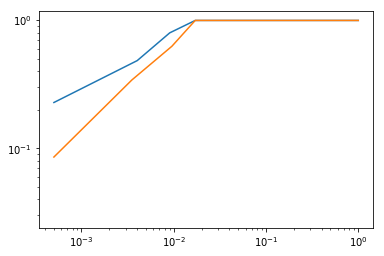

In [220]:
plt.plot(temp3, temp2);
plt.plot(temp6, temp5);
plt.yscale('log')
plt.xscale('log')

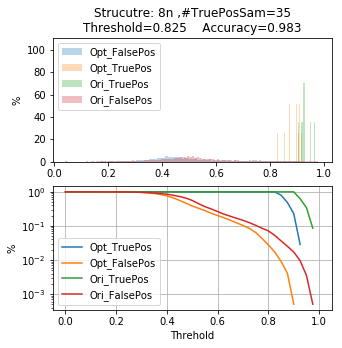

In [117]:
tmp_Threshold1, tmp_accuracy1 = fun_SGD_score_v2(best_weights,positive_training_data[load_structure], negative_training_data[load_structure])
tmp_Threshold0, tmp_accuracy0 = fun_SGD_score_v2(ori_best_weights,positive_training_data[load_structure], negative_training_data[load_structure])
plt.figure(figsize=(5,5))
plt.subplot(2,1,1)
tempBinNum = 100
tempNormed = True
tempCumulated = False
positive_weighted_similarity = np.dot(positive_training_data[load_structure], best_weights)
negative_weighted_similarity = np.dot(negative_training_data[load_structure], best_weights)
ori_positive_weighted_similarity = np.dot(positive_training_data[load_structure], ori_best_weights)
ori_negative_weighted_similarity = np.dot(negative_training_data[load_structure], ori_best_weights)
plt.hist(negative_weighted_similarity,bins=tempBinNum,normed=tempNormed, alpha=0.3,cumulative=tempCumulated, label='Opt_FalsePos');
plt.hist(positive_weighted_similarity,bins=tempBinNum,normed=tempNormed,alpha=0.3,cumulative=tempCumulated, label='Opt_TruePos');
plt.hist(ori_positive_weighted_similarity,bins=tempBinNum,normed=tempNormed,alpha=0.3,cumulative=tempCumulated, label='Ori_TruePos');
plt.hist(ori_negative_weighted_similarity,bins=tempBinNum,normed=tempNormed,alpha=0.3,cumulative=tempCumulated, label='Ori_FalsePos');
plt.ylabel('%')
plt.title('Strucutre: %s ,#TruePosSam=%d\nThreshold=%.3f    Accuracy=%.3f'%(load_structure, training_sample_num_pos_dic[load_structure],tmp_Threshold1, tmp_accuracy1))
plt.legend()


temp1, temp2, temp3 = fun_ROC(np.dot(positive_training_data[load_structure], best_weights), np.dot(negative_training_data[load_structure], best_weights) )
temp4, temp5, temp6 = fun_ROC(np.dot(positive_training_data[load_structure], ori_best_weights), np.dot(negative_training_data[load_structure], ori_best_weights) )
plt.subplot(2,1,2)
plt.plot(temp1, temp2,label='Opt_TruePos')
plt.yscale('log')
plt.xlabel('Threhold')
plt.ylabel('%')
plt.plot(temp1, temp3,label='Opt_FalsePos')
plt.plot(temp1, temp5,label='Ori_TruePos')
plt.plot(temp1, temp6,label='Ori_FalsePos')
plt.grid()
plt.legend()


# Best weight obtained for each structure

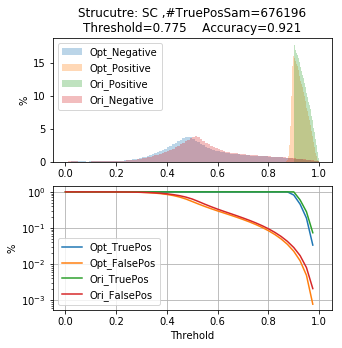

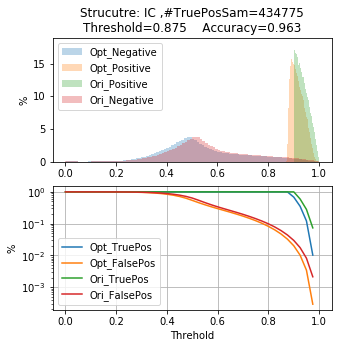

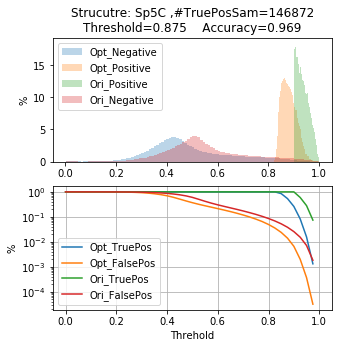

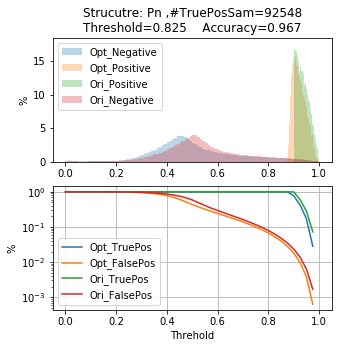

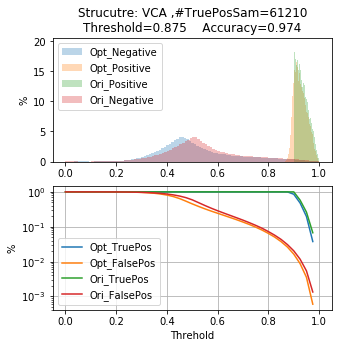

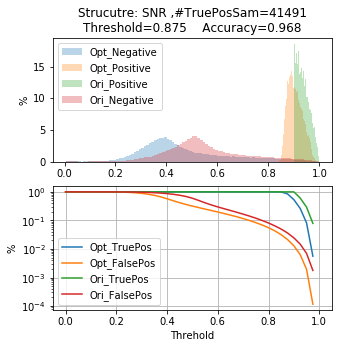

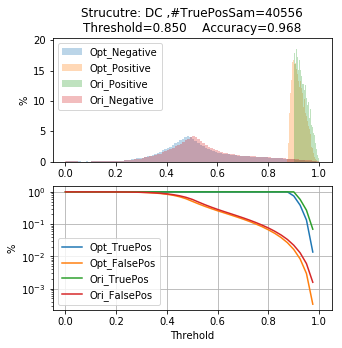

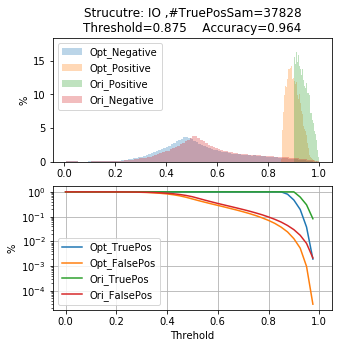

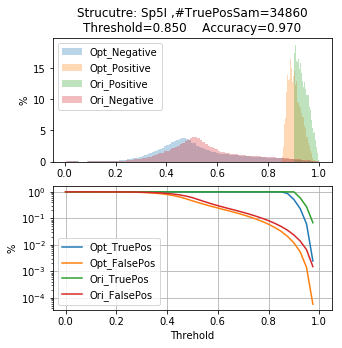

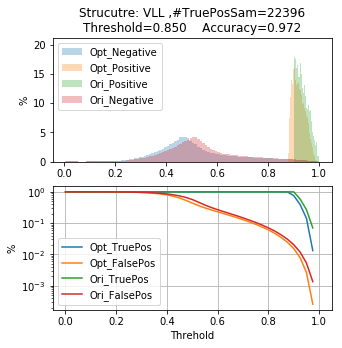

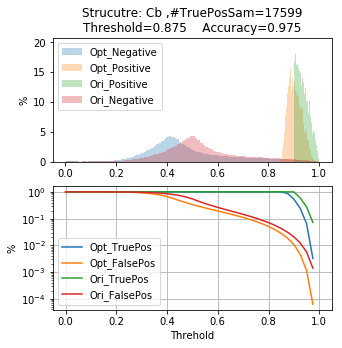

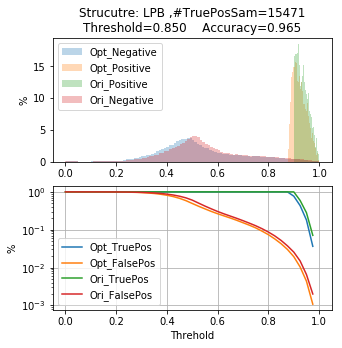

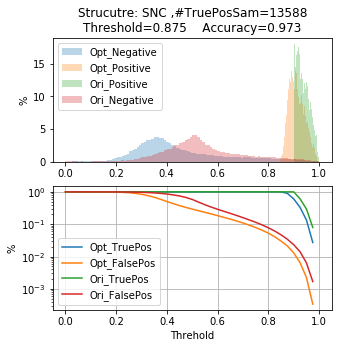

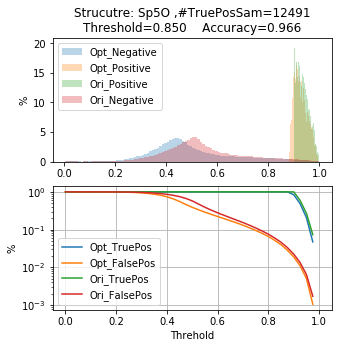

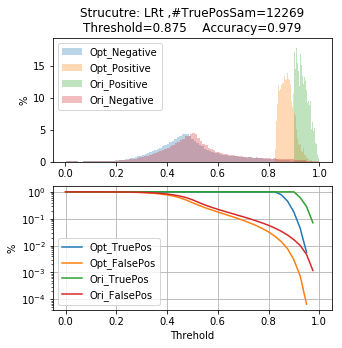

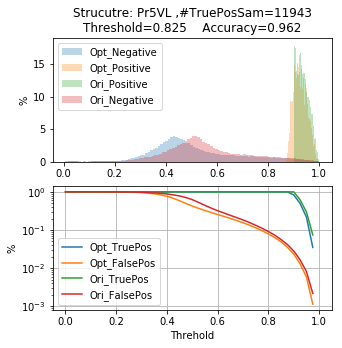

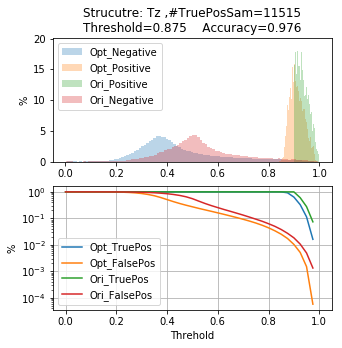

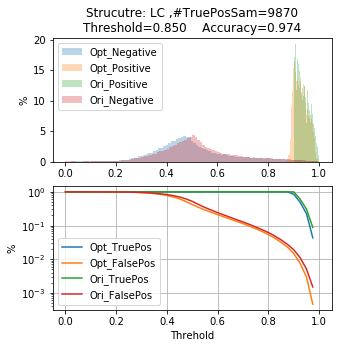

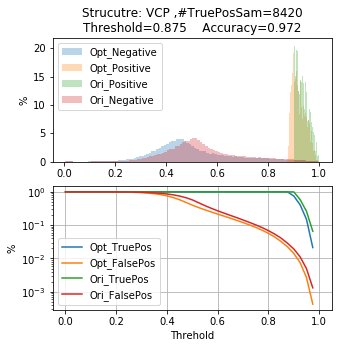

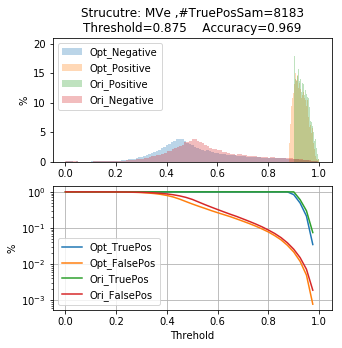

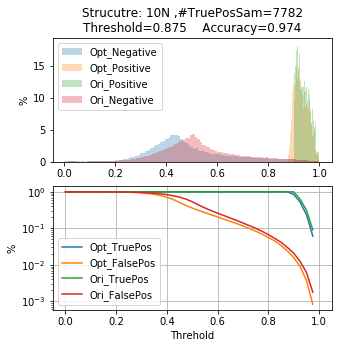

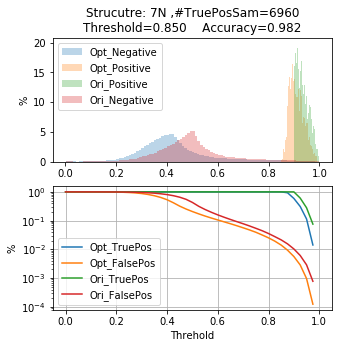

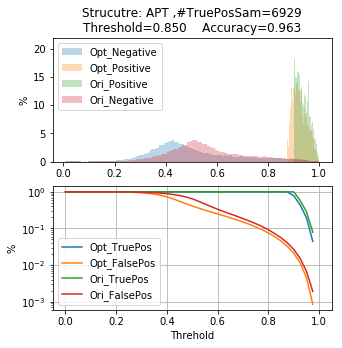

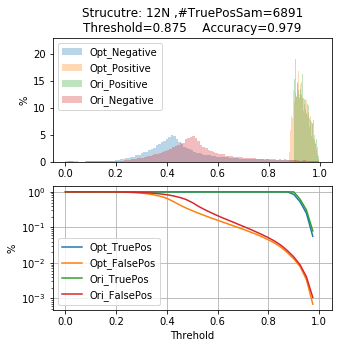

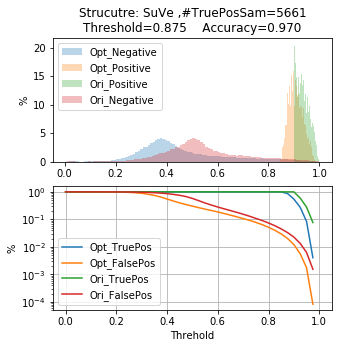

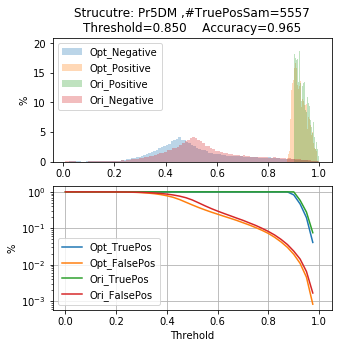

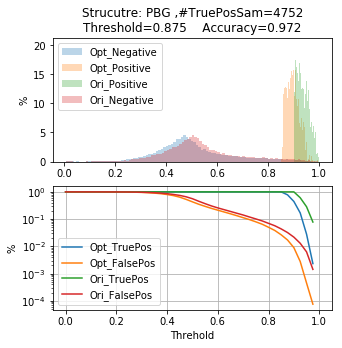

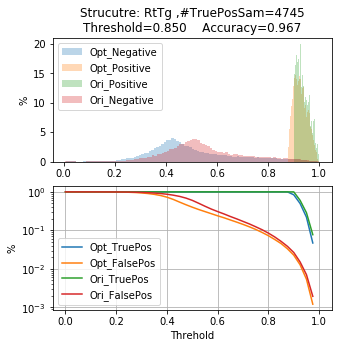

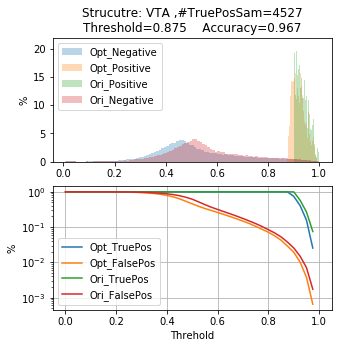

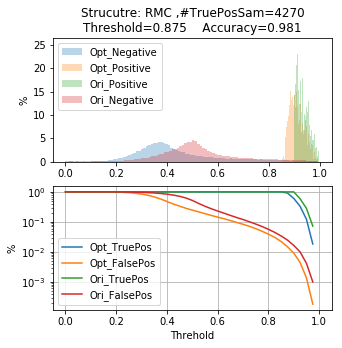

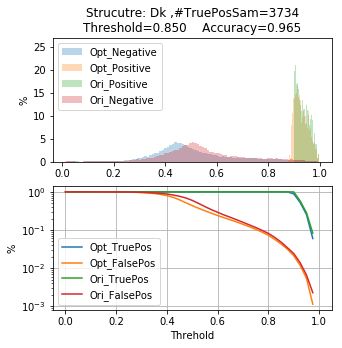

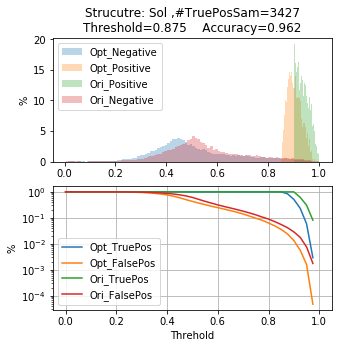

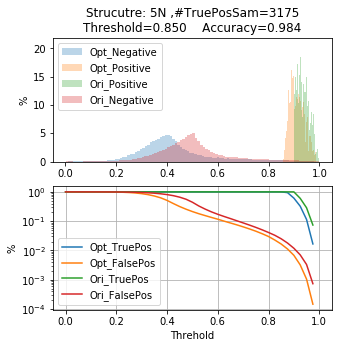

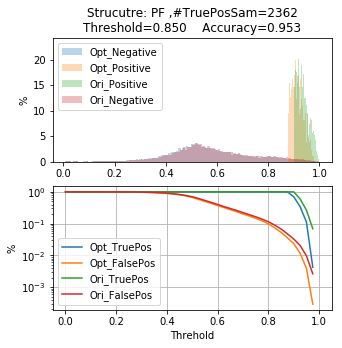

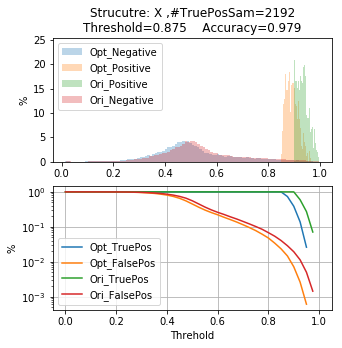

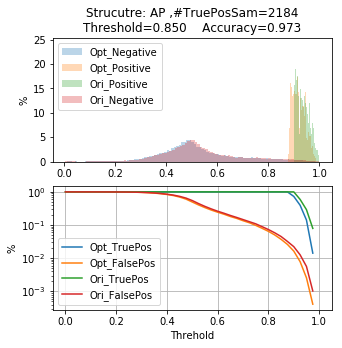

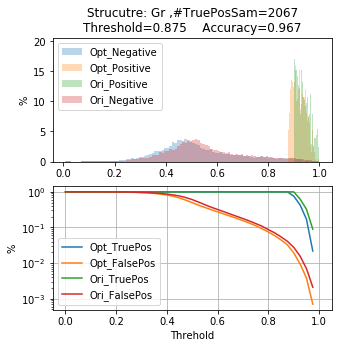

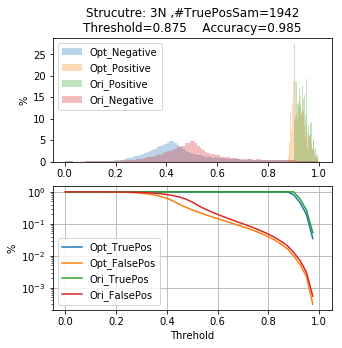

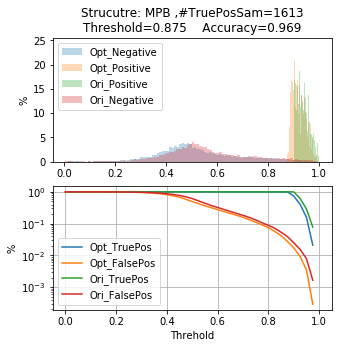

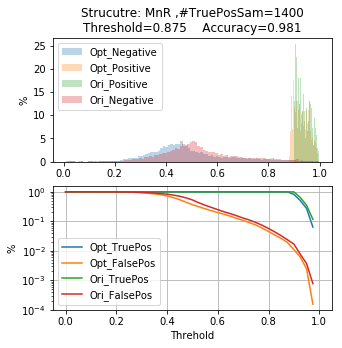

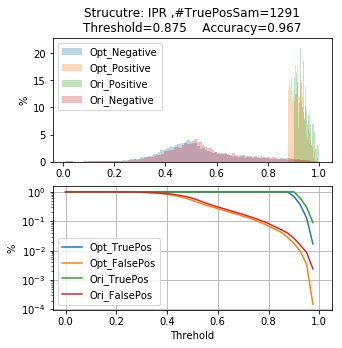

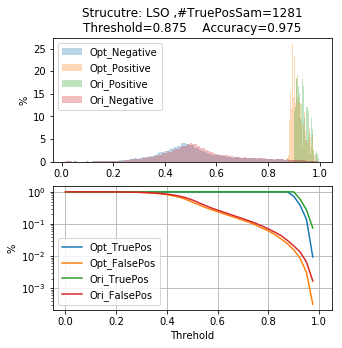

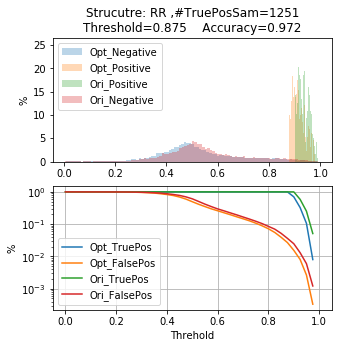

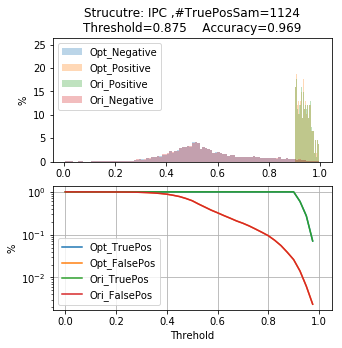

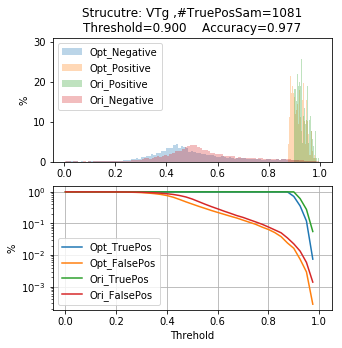

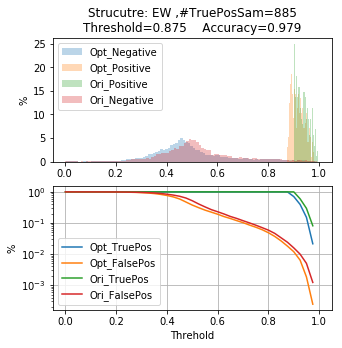

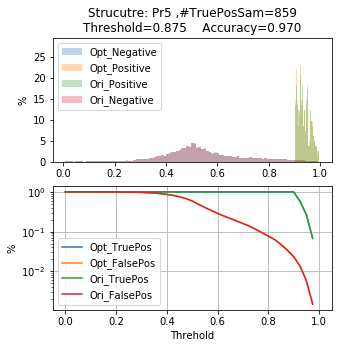

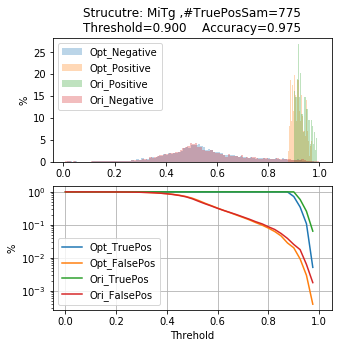

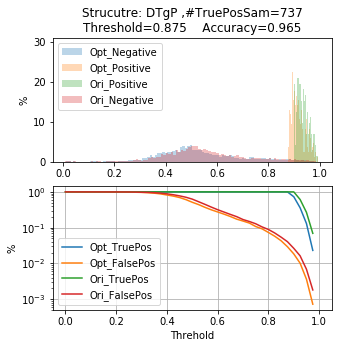

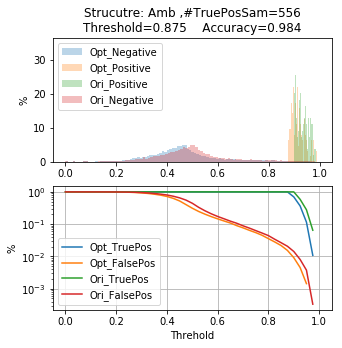

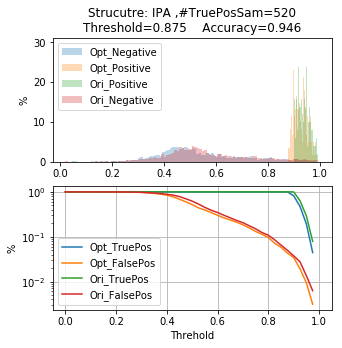

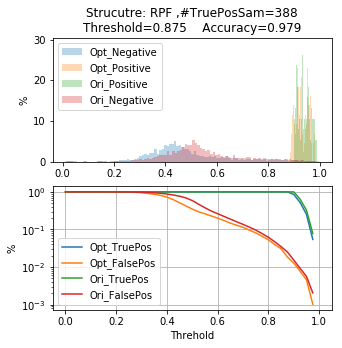

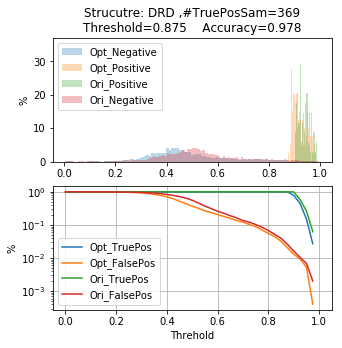

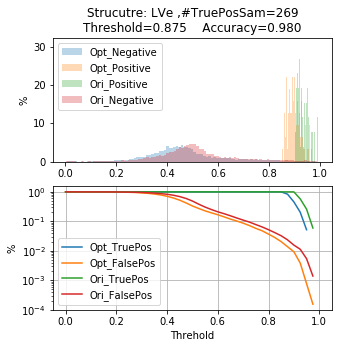

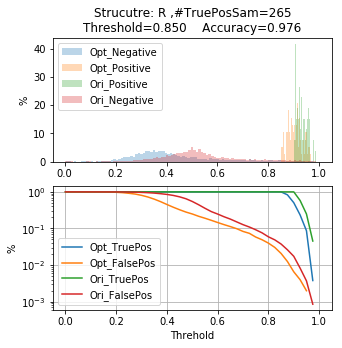

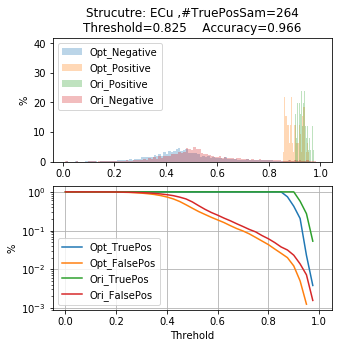

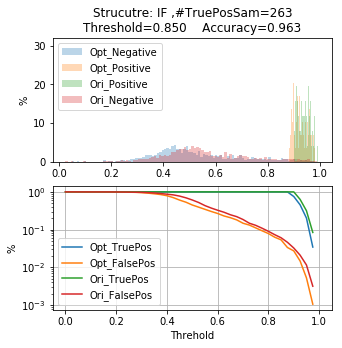

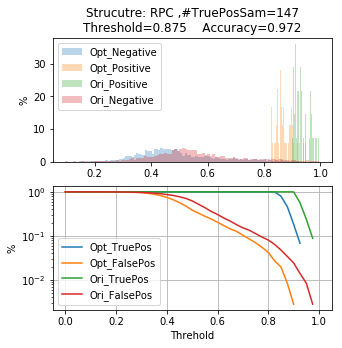

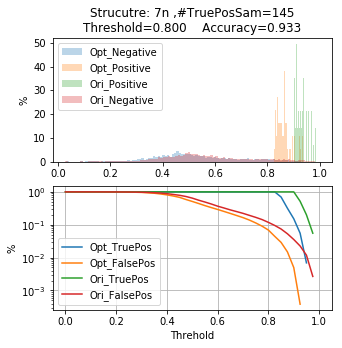

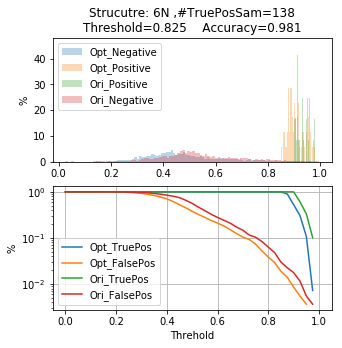

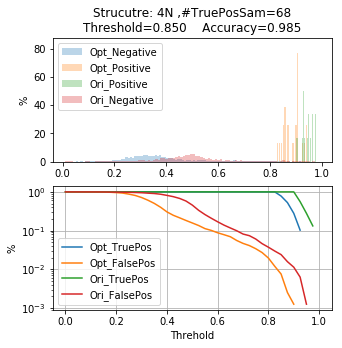

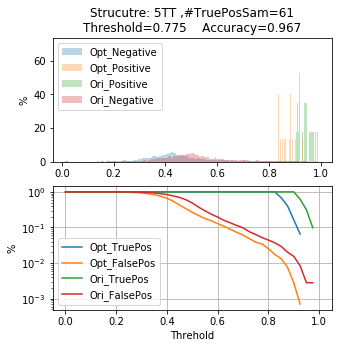

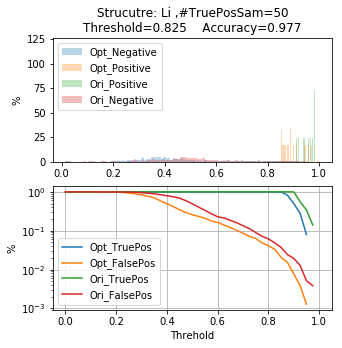

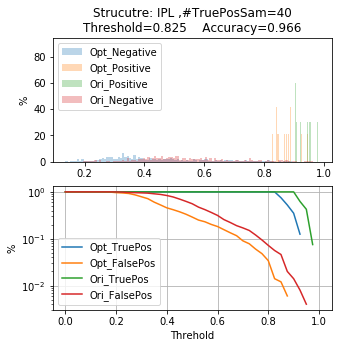

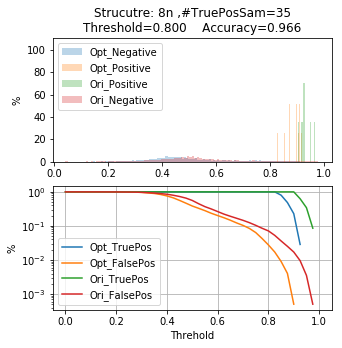

In [160]:
for load_structure in structure_name_list:
    tmp_Threshold1, tmp_accuracy1 = fun_SGD_score_v2(best_weights,positive_training_data[load_structure], negative_training_data[load_structure])
    best_weights,_ = fun_find_max(data_weight[load_structure], data_maxSimDiff[load_structure],mode='returnFirst')
    ori_best_weights = np.array([[0.5,0.5,0,0,0,0,0,0,0,0,0]]).T
    plt.figure(figsize=(5,5))
    plt.subplot(2,1,1)
    tempBinNum = 100
    tempNormed = True
    tempCumulated = False
    positive_weighted_similarity = np.dot(positive_training_data[load_structure], best_weights)
    negative_weighted_similarity = np.dot(negative_training_data[load_structure], best_weights)
    ori_positive_weighted_similarity = np.dot(positive_training_data[load_structure], ori_best_weights)
    ori_negative_weighted_similarity = np.dot(negative_training_data[load_structure], ori_best_weights)
    plt.hist(negative_weighted_similarity,bins=tempBinNum,normed=tempNormed, alpha=0.3,cumulative=tempCumulated, label='Opt_Negative');
    plt.hist(positive_weighted_similarity,bins=tempBinNum,normed=tempNormed,alpha=0.3,cumulative=tempCumulated, label='Opt_Positive');
    plt.hist(ori_positive_weighted_similarity,bins=tempBinNum,normed=tempNormed,alpha=0.3,cumulative=tempCumulated, label='Ori_Positive');
    plt.hist(ori_negative_weighted_similarity,bins=tempBinNum,normed=tempNormed,alpha=0.3,cumulative=tempCumulated, label='Ori_Negative');
    plt.ylabel('%')
    plt.title('Strucutre: %s ,#TruePosSam=%d\nThreshold=%.3f    Accuracy=%.3f'%(load_structure, training_sample_num_pos_dic[load_structure],tmp_Threshold1, tmp_accuracy1))
    plt.legend()


    temp1, temp2, temp3 = fun_ROC(np.dot(positive_training_data[load_structure], best_weights), np.dot(negative_training_data[load_structure], best_weights) )
    temp4, temp5, temp6 = fun_ROC(np.dot(positive_training_data[load_structure], ori_best_weights), np.dot(negative_training_data[load_structure], ori_best_weights) )
    plt.subplot(2,1,2)
    plt.plot(temp1, temp2,label='Opt_TruePos')
    plt.yscale('log')
    plt.xlabel('Threhold')
    plt.ylabel('%')
    plt.plot(temp1, temp3,label='Opt_FalsePos')
    plt.plot(temp1, temp5,label='Ori_TruePos')
    plt.plot(temp1, temp6,label='Ori_FalsePos')
    plt.grid()
    plt.legend()


Based on the training data, the weights are initialized randomly. With this weight, we calculate the initial weighted similarities for both positive and negative data. We look for a threshold of the similarity to determine the true positive rate ( the ratio that positive sample with weighted similarity larger than the threshold) and the false positive rate( the ratio of negative samples with weighted similarity larger than the threshold). Then, stochastic gradient descent is used to maximized the difference between the true positive rate and false positive rate( defined as accuracy ) by optimizing the weight vecotr. 

The result of optimization for each strucutre is illustreated in 2 sub-figures. The top one shows the weighted similarity distribution of the positive and negative training samples. Here we compare the weighted similarity distribution given by the original weight vector ( {w_area, w_eccentricity} = {0.5, 0.5} ) to the distribution given by the optimized weight vector. 

For some strucutres, the optimized weight can differentiate positive sample against negative sample by lowering the weighted similarity of negative samples more than the positive sample. The optimization goal is to maximize the accuracy, even when the threhsold is lower, the optimized weights gives similar accuracy with the original weight. Later, we can just increase the threshold to further reduce the false positive rate ( sicne we actually don't know what kind of blobs are 'typical' in the annotated structures, I think it's fine to drop some of the less similar blobs in the positive sample to further descrease the false-positive rate). 




### Similarity between optimized weight vectors

We got optimized weight vecotres for each structures. If they are similar with each other, we can simple use one, or their average to collect typical blobs later. Here, we compute the L2 distance between weight vectors of each structure. Since all the weight are normalized, we defien the similarity between two weight vectors as (1 - their L2 distance). The result is shown in the following matrix plot. 

In [139]:
def fun_vector_distance_L2(vec1, vec2):
    return np.linalg.norm(np.array(vec1)-np.array(vec2))
def fun_vector_distance_cos(vec1, vec2):
    vec1 = np.array(vec1.flatten(), dtype=np.float)
    vec2 = np.array(vec2.flatten(), dtype=np.float)
    cos_angle = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    return cos_angle

In [127]:
best_weight = {}
for structure_name in data_weight.keys():
    best_weight[structure_name] =  fun_find_max(data_weight[structure_name], data_maxSimDiff[structure_name], mode='returnFirst')[0].flatten()

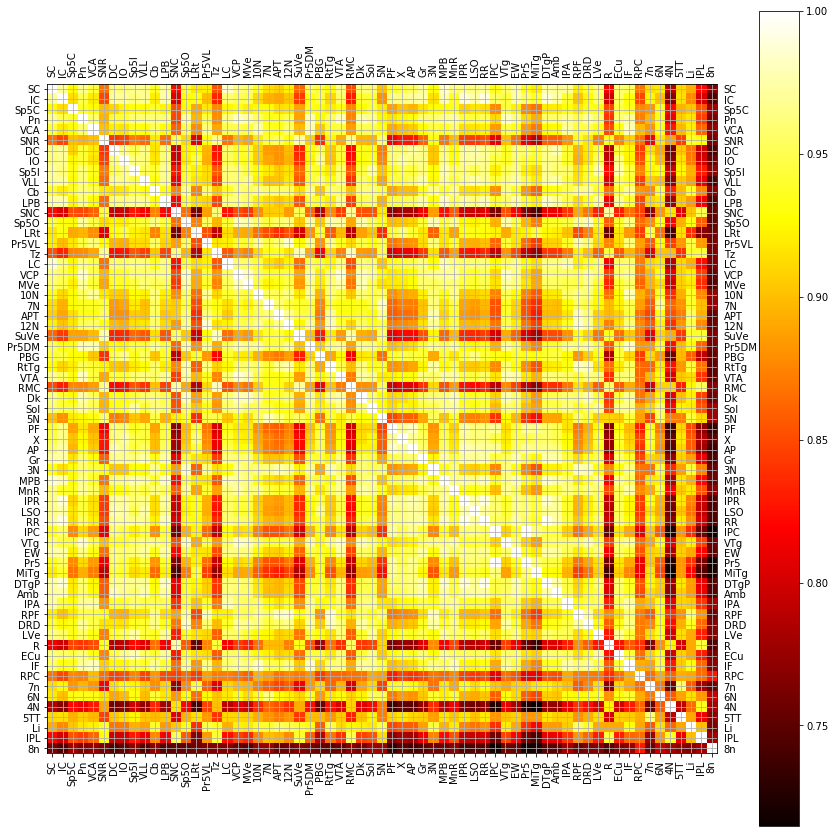

In [137]:
# structure_list = np.sort(structure_name_list)
structure_list = structure_name_list
# structure_list = np.sort(best_weight.keys())
tempList = []
for temp in structure_list:
    tempList.append(best_weight[temp])
best_weight_flatten = np.column_stack(tuple(tempList))
# Similarity between best weight vector
weight_vector_simi_mat = np.array([[1-fun_vector_distance_L2(best_weight[temp1], best_weight[temp2]) for temp1 in structure_list] for temp2 in structure_list])
plt.figure(figsize=(15,15))
plt.imshow(weight_vector_simi_mat,cmap=plt.cm.hot)
plt.colorbar()
plt.xticks(np.arange(0, len(structure_list)),structure_list, rotation='vertical');
plt.yticks(np.arange(0, len(structure_list)),structure_list);
plt.tick_params(labelbottom='on',labeltop='on')
plt.tick_params(labelleft='on',labelright='on')
plt.grid()

In this figure, the name of the strucutre are sorted according to the number of positive training samples. Some strucutres have less positive training sample and therefore might be more different from other weight vectors. This is the reason that structures like R, CEu, IF, RPC, 7n ...  seems to have more different weight vector. 

The following figure shows the wegiht of each feature for each structures. Area and eccentricity are dominant features. The optimized weight are quite closed to the original weight we set for blob collection. Therefore, I am not sure how does this initial weight vectore impact the final outcomes. And optional experiment is to perturb the initial weight vector, collect the blobs and optimized the same learning feature combinations again. 


In [164]:
learning_features = ['area', 'eccentricity', 'orientation','compactness', 'moments_hu1','moments_hu2', 
                     'moments_hu3', 'moments_hu4', 'moments_hu5', 'moments_hu6', 'moments_hu7']

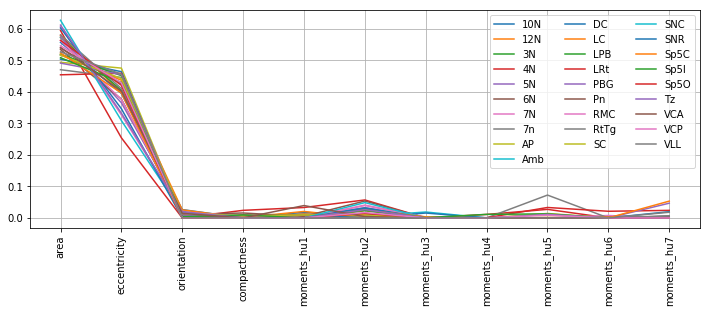

In [181]:
plt.figure(figsize=(12,4))
for tmp in STRUCTURES_LIST:
    plt.plot(np.arange(0, len(learning_features)), best_weight[tmp], label=tmp)
ax = plt.subplot(1,1,1)

plt.xticks(np.arange(0, len(learning_features)), learning_features, rotation='vertical')
ax.legend(ncol=3)
plt.grid()

### Best weight vector averaged

Here we compute the average of the best weight vector. The features in the weight vector are arranged in the following order:

['area', 'eccentricity', 'orientation','compactness', 'moments_hu1','moments_hu2', 'moments_hu3', 'moments_hu4', 'moments_hu5', 'moments_hu6', 'moments_hu7']

The average best weight is quite similar with our pre-set weight. Using this feature weight might give better collecting result (not sure), but will significantly increase the computational load. 

In [183]:
average_best_weight = np.mean(np.vstack(tuple(best_weight[tmp] for tmp in structure_name_list)), axis=0)
average_best_weight

array([ 0.53655065,  0.41277178,  0.00709985,  0.00467006,  0.00534061,
        0.01494578,  0.00160225,  0.00193243,  0.00827768,  0.00214731,
        0.0046616 ])

The distance between the averaged vector and the best weight vectors of each structure are given below. The structures that have similarity less than 0.9 are : 
['SNC', 'LRt', 'Tz', 'SuVe', 'RMC', 'MiTg', 'R', 'RPC', '4N', 'IPL', '8n']


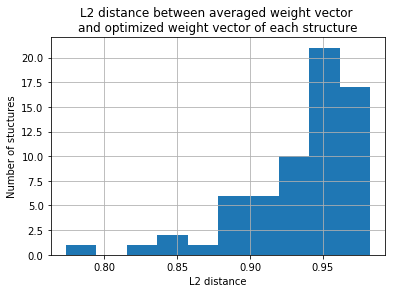

In [194]:
dist_avg_best_weights = np.array([1-fun_vector_distance_L2(best_weight[tmp], average_best_weight) for tmp in structure_name_list])
plt.hist(dist_avg_best_weights);
plt.xlabel('L2 distance')
plt.ylabel('Number of stuctures')
plt.title('L2 distance between averaged weight vector \nand optimized weight vector of each structure')
plt.grid()

In [192]:
structure_name_list[np.where(dist_avg_best_weights<0.9)]

array(['SNC', 'LRt', 'Tz', 'SuVe', 'RMC', 'MiTg', 'R', 'RPC', '4N', 'IPL',
       '8n'],
      dtype='|S5')

In [141]:
best_weight['SNR']

array([ 0.60215005,  0.34618949,  0.        ,  0.        ,  0.        ,
        0.0319032 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01975725])

In [143]:
best_weight['SC']

array([ 0.51661404,  0.44162234,  0.0143826 ,  0.0066495 ,  0.00957605,
        0.00989628,  0.        ,  0.        ,  0.00125918,  0.        ,  0.        ])

# Overall statistics

For each stucture, we run stochastic gradient descent for 10000 times and get 10000 optimized weight. The discussion above are on the best weight vector for each structure( which gives the highest accuracy). Here we look at the distribution of features among all the sub-optimized weight vectors. They might be good weight vector, but are relatively more different from the initial weight vectors( which might be a good thing? ).

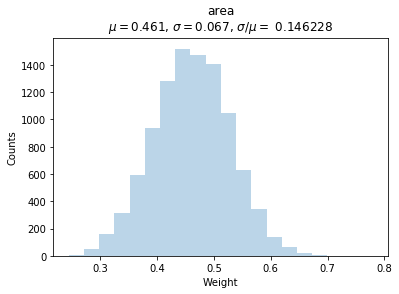

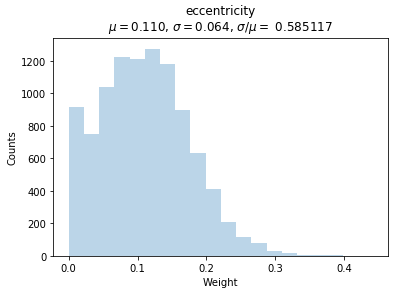

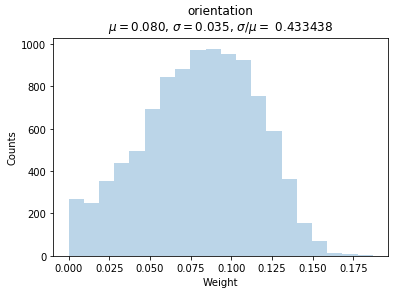

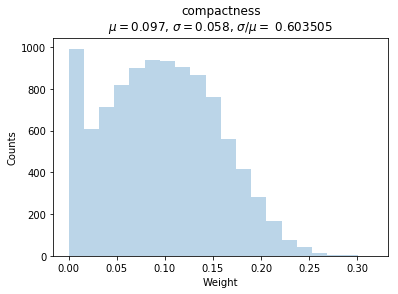

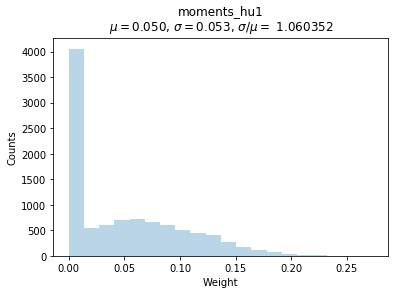

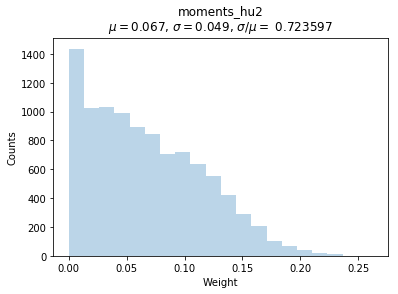

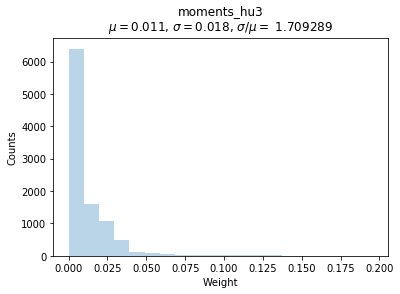

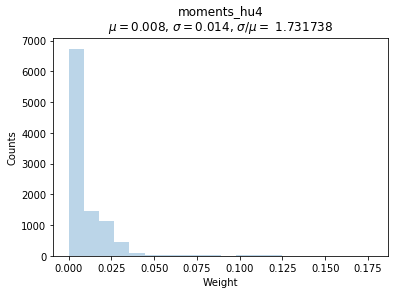

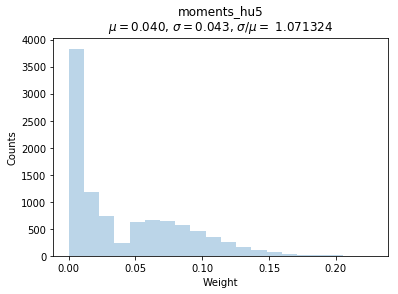

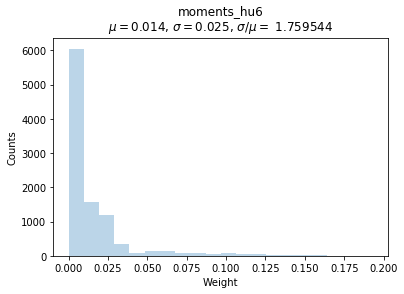

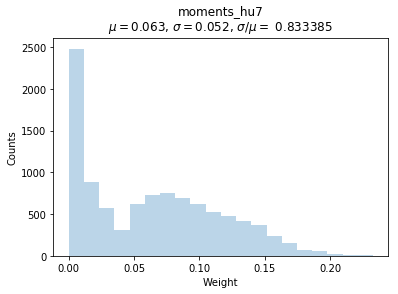

In [212]:
avg_weight = {}
std_weight = {}
err_weight = {}
tempTitle = learning_features
tempNormalized = False
for tempIdx in range(11):
    plt.figure()
    tmp_data = data_weight[load_structure][:, tempIdx, 0]
    avg_weight[learning_features[tempIdx]] = np.mean(tmp_data)
    std_weight[learning_features[tempIdx]] = np.std(tmp_data)
    err_weight[learning_features[tempIdx]] = np.std(tmp_data)/np.mean(tmp_data)

    plt.hist(tmp_data, bins=20, normed=tempNormalized, alpha=0.3);
    plt.title('%s\n$\mu=$%.3f, $\sigma=$%.3f, $\sigma/\mu=$ %f'%(tempTitle[tempIdx], avg_weight[learning_features[tempIdx]], std_weight[learning_features[tempIdx]],err_weight[learning_features[tempIdx]] ))
    plt.xlabel('Weight')
    plt.ylabel('Counts')

The average of the weights for each features are shown below. Area is again an important features, but eccentricity is no longer another dominant features. There are several important features indicated by this result: compactness, eccentricity, orientation, some of the components of the hu moments. It seems consistant that hu moments 3,4,6 are not important features, since most of the sub-optimized result have pretty low value and concentricated distribution. 

Is this averaged weight vector a better one to use later? It seems not unreasonable, though the error ( average / standard deviation ) for some features are quite large, due to the flat distribution. 

In [213]:
avg_weight

{'area': 0.46089553238506253,
 'compactness': 0.096575439707968502,
 'eccentricity': 0.10986143521955989,
 'moments_hu1': 0.04951754416146794,
 'moments_hu2': 0.067311100281247996,
 'moments_hu3': 0.010526490850732179,
 'moments_hu4': 0.0080315696915363218,
 'moments_hu5': 0.040267585264476109,
 'moments_hu6': 0.014024581495322732,
 'moments_hu7': 0.062706091132220351,
 'orientation': 0.080282629810405404}

In [214]:
std_weight

{'area': 0.067396035613113733,
 'compactness': 0.058283733127375982,
 'eccentricity': 0.064281812444651018,
 'moments_hu1': 0.052506050189542387,
 'moments_hu2': 0.048706091432444351,
 'moments_hu3': 0.017992810766367447,
 'moments_hu4': 0.013908574883933843,
 'moments_hu5': 0.043139623656279338,
 'moments_hu6': 0.024676864169830368,
 'moments_hu7': 0.052258329824599388,
 'orientation': 0.034797521397436644}

In [215]:
err_weight

{'area': 0.14622844197328136,
 'compactness': 0.60350471407242223,
 'eccentricity': 0.58511717343017366,
 'moments_hu1': 1.0603524685781964,
 'moments_hu2': 0.72359672073304737,
 'moments_hu3': 1.7092885959346977,
 'moments_hu4': 1.7317380559606819,
 'moments_hu5': 1.0713238296495751,
 'moments_hu6': 1.7595437110234073,
 'moments_hu7': 0.83338522432228956,
 'orientation': 0.43343773714954403}